In [2]:
#https://www.nixtla.io/
#https://www.analyticsvidhya.com/blog/2024/02/timegpt-revolutionizing-time-series-forecasting/
#https://arxiv.org/pdf/2310.01728.pdf
#https://github.com/KimMeen/Time-LLM

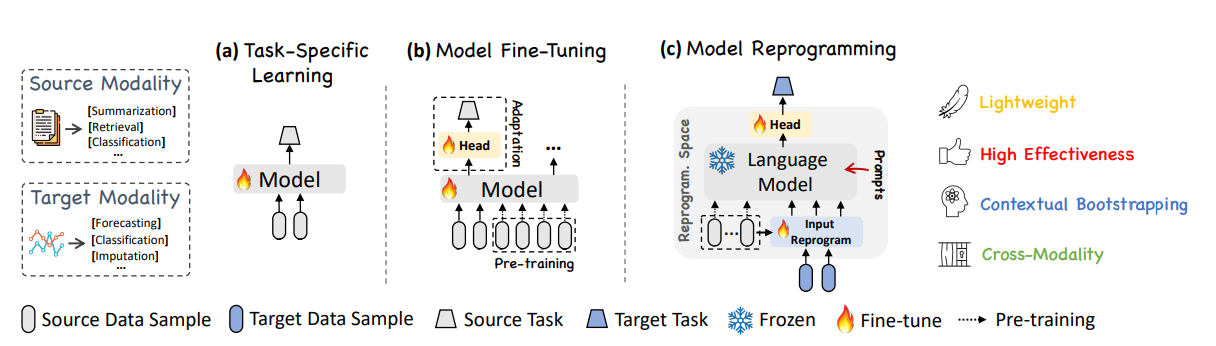

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from nixtlats import TimeGPT

## Data Reading and Processing

In [6]:
file_path = "walmart.csv"
df = pd.read_csv(file_path)

#Covert Date into Datetime Format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Set "Date" column as index
df.set_index('Date', inplace=True)

# Resample data into Weekly frequency. Although this is not required. Keeping it so that one can change into 'MS' if needed.
df_resampled = df.resample('W').sum()

df_resampled.reset_index(inplace=True)

df_resampled = df_resampled[["Date","Weekly_Sales"]]

print(df_resampled.head())

        Date  Weekly_Sales
0 2010-02-07   49750740.50
1 2010-02-14   48336677.63
2 2010-02-21   48276993.78
3 2010-02-28   43968571.13
4 2010-03-07   46871470.30


## Data Visualization

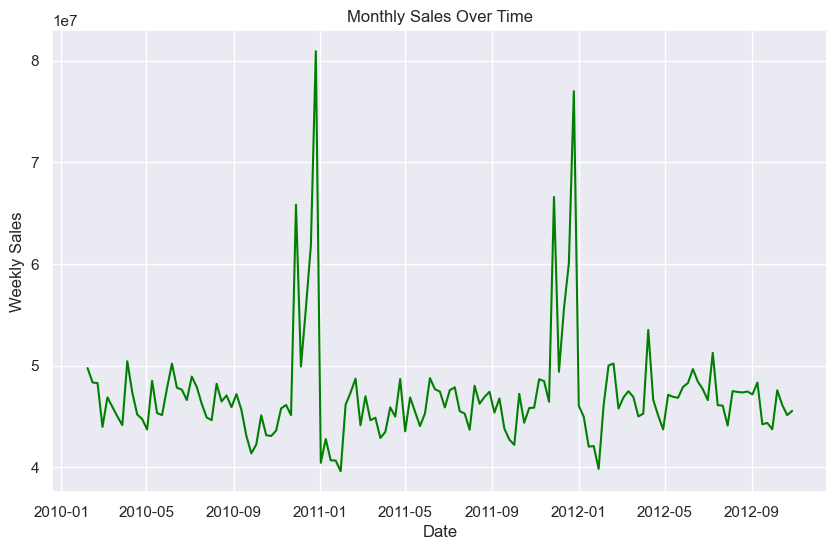

In [8]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="Date", y='Weekly_Sales', data=df_resampled, color='green')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

## STL Decomposition of the Data

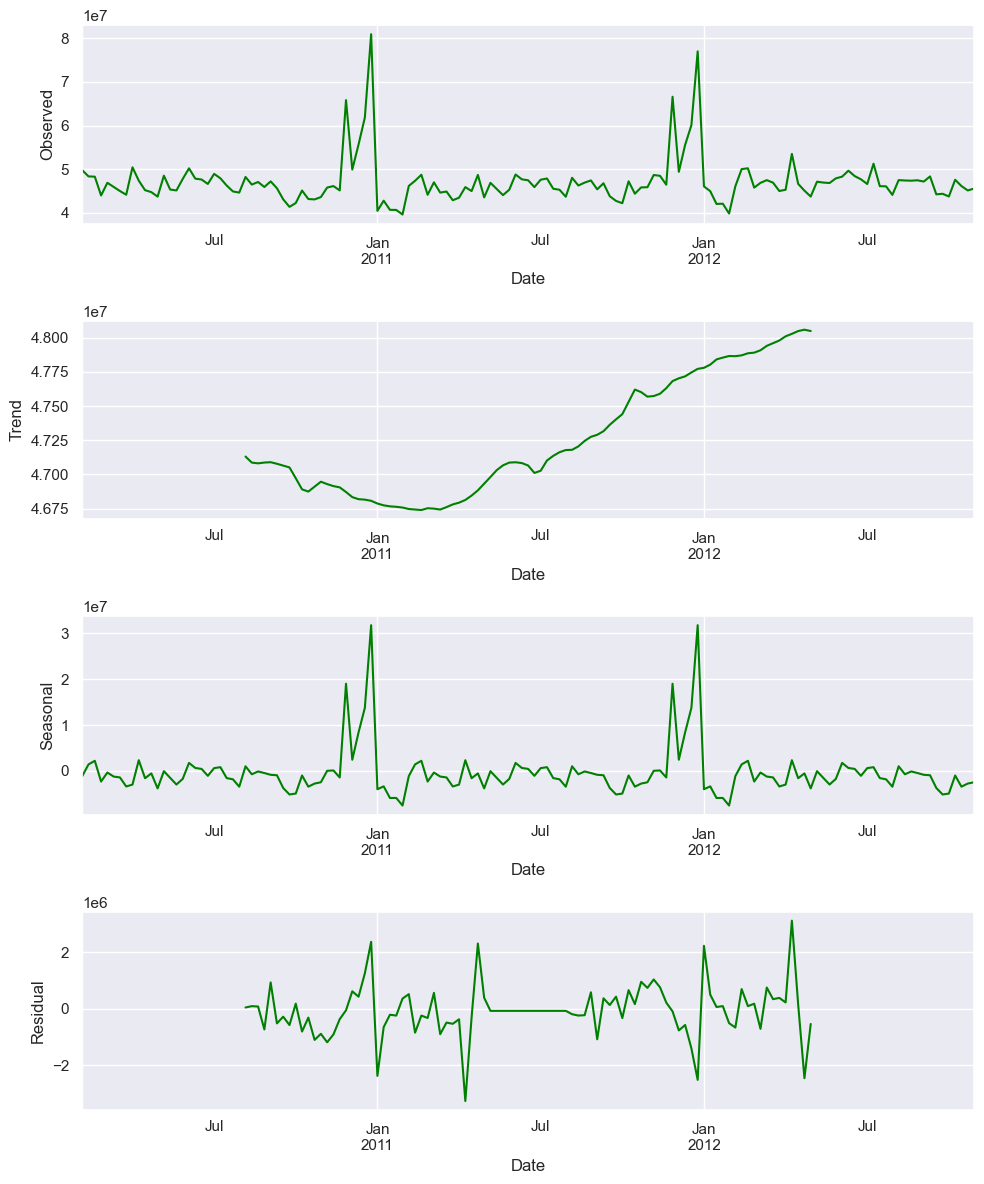

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

df_resampled.set_index('Date', inplace=True)
result = seasonal_decompose(df_resampled['Weekly_Sales'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

result.observed.plot(ax=ax1, color='green')
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2, color='green')
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3, color='green')
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4, color='green')
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

## Train & Test Split

In [10]:
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled.iloc[:train_size], df_resampled.iloc[train_size:]

print(f'Train set size: {len(train)}')
print(f'Test set size: {len(test)}')

Train set size: 114
Test set size: 29


In [15]:
train['Date'] = train.index
test['Date'] = test.index

C:\Users\Abhishek_Jaiswal\AppData\Local\Temp\ipykernel_34688\1187875590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = train.index
C:\Users\Abhishek_Jaiswal\AppData\Local\Temp\ipykernel_34688\1187875590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = test.index


In [17]:
train
#train.index

,Weekly_Sales,Date
Date,,
2010-02-07,49750740.50,2010-02-07
2010-02-14,48336677.63,2010-02-14
2010-02-21,48276993.78,2010-02-21
2010-02-28,43968571.13,2010-02-28
2010-03-07,46871470.30,2010-03-07
...,...,...
2012-03-11,47480454.11,2012-03-11
2012-03-18,46901504.94,2012-03-18
2012-03-25,44993794.45,2012-03-25


## Forecasting with StatsForecast – AutoARIMA

In [18]:
train_ = pd.DataFrame({'unique_id':[1]*len(train),'ds': train["Date"], "y":train["Weekly_Sales"]})
test_ = pd.DataFrame({'unique_id':[1]*len(test),'ds': test["Date"], "y":test["Weekly_Sales"]})

sf = StatsForecast(models = [AutoARIMA(season_length = 52)],freq = 'W')

sf.fit(train_)
sf_prediction = sf.predict(h=len(test))
sf_prediction.rename(columns={'ds': 'Date'}, inplace=True)

C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [19]:
sf_prediction

,Date,AutoARIMA
unique_id,,
1,2012-04-15,48190620.0
1,2012-04-22,51893984.0
1,2012-04-29,46747324.0
1,2012-05-06,50079252.0
1,2012-05-13,48663436.0
1,2012-05-20,47263888.0
1,2012-05-27,48510748.0
1,2012-06-03,51989284.0
1,2012-06-10,50887028.0


## Forecasting with MLForecast – Linear Regression, LGBM Regression, XGB Regression and Random Forest Regression

In [20]:
models = [LinearRegression(),
    lgb.LGBMRegressor(verbosity=-1),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]
@njit
def rolling_mean_7(x):
    return rolling_mean(x, window_size=7)
@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)
    
#Defining the Model Parameters
fcst = MLForecast(models=models,freq='W',lags=[7,14,28],
    lag_transforms={
        1: [expanding_mean],
        7: [rolling_mean_7, rolling_mean_14],
        14: [rolling_mean_7, rolling_mean_14]
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],
    target_transforms=[Differences([7])])
    
#Fitting the Model and Generating Forecasts
fcst.fit(train_)
ml_prediction = fcst.predict(len(test_))
ml_prediction.rename(columns={'ds': 'Date'}, inplace=True)

In [21]:
ml_prediction

,unique_id,Date,LinearRegression,LGBMRegressor,XGBRegressor,RandomForestRegressor
0,1,2012-04-15,4.184221e+07,4.758883e+07,4.827244e+07,4.583376e+07
1,1,2012-04-22,5.063865e+07,5.128578e+07,4.684492e+07,4.630367e+07
2,1,2012-04-29,4.372516e+07,4.966874e+07,4.859913e+07,4.675738e+07
3,1,2012-05-06,4.629398e+07,4.458644e+07,4.510829e+07,4.590455e+07
4,1,2012-05-13,4.846285e+07,4.547622e+07,4.637477e+07,4.629285e+07
5,1,2012-05-20,5.633588e+07,4.902203e+07,4.518588e+07,4.660480e+07
6,1,2012-05-27,4.759709e+07,5.139651e+07,5.295547e+07,5.271923e+07
7,1,2012-06-03,4.266039e+07,4.295058e+07,4.696965e+07,4.618368e+07
8,1,2012-06-10,4.890681e+07,4.220633e+07,4.788388e+07,4.648442e+07
9,1,2012-06-17,4.705928e+07,4.422534e+07,4.673019e+07,4.639994e+07


## TimeGPT Model

In [ ]:
#Importing TimeGPT
#https://www.nixtla.io/#tgpt
from nixtlats import TimeGPT
os.environ['TIMEGPT_TOKEN'] = "Your Token"
timegpt = TimeGPT(token=os.environ['TIMEGPT_TOKEN'])

In [ ]:
timegpt.plot(df_resampled, time_col='Date', target_col='Weekly_Sales')

In [ ]:
timegpt_fcst = timegpt.forecast(df=train, h=len(test), time_col='Date', target_col='Weekly_Sales', freq='W')
print(timegpt_fcst.head())

## Assessment of Accuracy Metrics for Time Series Forecasting

In [22]:
#We will use Six key metrices namely MAE, RMSE, MAPE, SMAPE, MdAPE, GMRAE.


In [27]:
result = test.copy()
#result.drop("index", axis=1, inplace=True)
result.set_index("Date", inplace=True)
result["AutoARIMA_fcst"]=sf_prediction["AutoARIMA"].values
result["LinearRegression_fcst"]=ml_prediction["LinearRegression"].values
result["LGBM_fcst"]=ml_prediction["LGBMRegressor"].values
result["XGB_fcst"]=ml_prediction["XGBRegressor"].values
result["RandomForest_fcst"]=ml_prediction["RandomForestRegressor"].values
#result["TimeGPT_fcst"]=timegpt_fcst["TimeGPT"].values
#print(result.head())
result

,Weekly_Sales,AutoARIMA_fcst,LinearRegression_fcst,LGBM_fcst,XGB_fcst,RandomForest_fcst
Date,,,,,,
2012-04-15,46629261.41,48190620.0,4.184221e+07,4.758883e+07,4.827244e+07,4.583376e+07
2012-04-22,45072529.78,51893984.0,5.063865e+07,5.128578e+07,4.684492e+07,4.630367e+07
2012-04-29,43716798.89,46747324.0,4.372516e+07,4.966874e+07,4.859913e+07,4.675738e+07
2012-05-06,47124197.93,50079252.0,4.629398e+07,4.458644e+07,4.510829e+07,4.590455e+07
2012-05-13,46925878.99,48663436.0,4.846285e+07,4.547622e+07,4.637477e+07,4.629285e+07
2012-05-20,46823939.22,47263888.0,5.633588e+07,4.902203e+07,4.518588e+07,4.660480e+07
2012-05-27,47892463.31,48510748.0,4.759709e+07,5.139651e+07,5.295547e+07,5.271923e+07
2012-06-03,48281649.72,51989284.0,4.266039e+07,4.295058e+07,4.696965e+07,4.618368e+07
2012-06-10,49651171.78,50887028.0,4.890681e+07,4.220633e+07,4.788388e+07,4.648442e+07


In [30]:
import numpy as np

def calculate_error_metrics(actual_values, predicted_values):
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    metrics_dict = {
        'MAE': np.mean(np.abs(actual_values - predicted_values)),
        'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),
        'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'SMAPE': 100 * np.mean(2 * np.abs(predicted_values - actual_values) / (np.abs(predicted_values) + np.abs(actual_values))),
        'MdAPE': np.median(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'GMRAE': np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values)))
    }

    result_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    return result_df

# Extract 'Weekly_Sales' as actuals
actuals = result['Weekly_Sales']


error_metrics_dict = {}


for col in result.columns[1:]:  # Exclude 'Weekly_Sales'
    predicted_values = result[col]
    error_metrics_dict[col] = calculate_error_metrics(actuals, predicted_values)['Value'].values  # Extracting 'Value' column


error_metrics_df = pd.DataFrame(error_metrics_dict)
error_metrics_df.insert(0, 'Metric', calculate_error_metrics(actuals, actuals)['Metric'].values)  # Adding 'Metric' column


error_metrics_df

C:\Users\Abhishek_Jaiswal\AppData\Local\Temp\ipykernel_34688\506336145.py:13: RuntimeWarning: divide by zero encountered in log
  'GMRAE': np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values)))


,Metric,AutoARIMA_fcst,LinearRegression_fcst,LGBM_fcst,XGB_fcst,RandomForest_fcst
0,MAE,2.438376e+06,4.923236e+06,3.590455e+06,2.149080e+06,1.977053e+06
1,RMSE,2.775494e+06,6.836633e+06,4.214252e+06,2.672837e+06,2.492108e+06
2,MAPE,5.267297e+00,1.076790e+01,7.663017e+00,4.596565e+00,4.208990e+00
3,SMAPE,5.093220e+00,9.861231e+00,7.659919e+00,4.542678e+00,4.180090e+00
4,MdAPE,5.280470e+00,6.030154e+00,6.204948e+00,3.498335e+00,2.731467e+00
5,GMRAE,4.306180e-02,5.429682e-02,6.221986e-02,3.396033e-02,2.953477e-02


## Let’s Visualize the Difference between Actuals and Predicted for each of the methods.

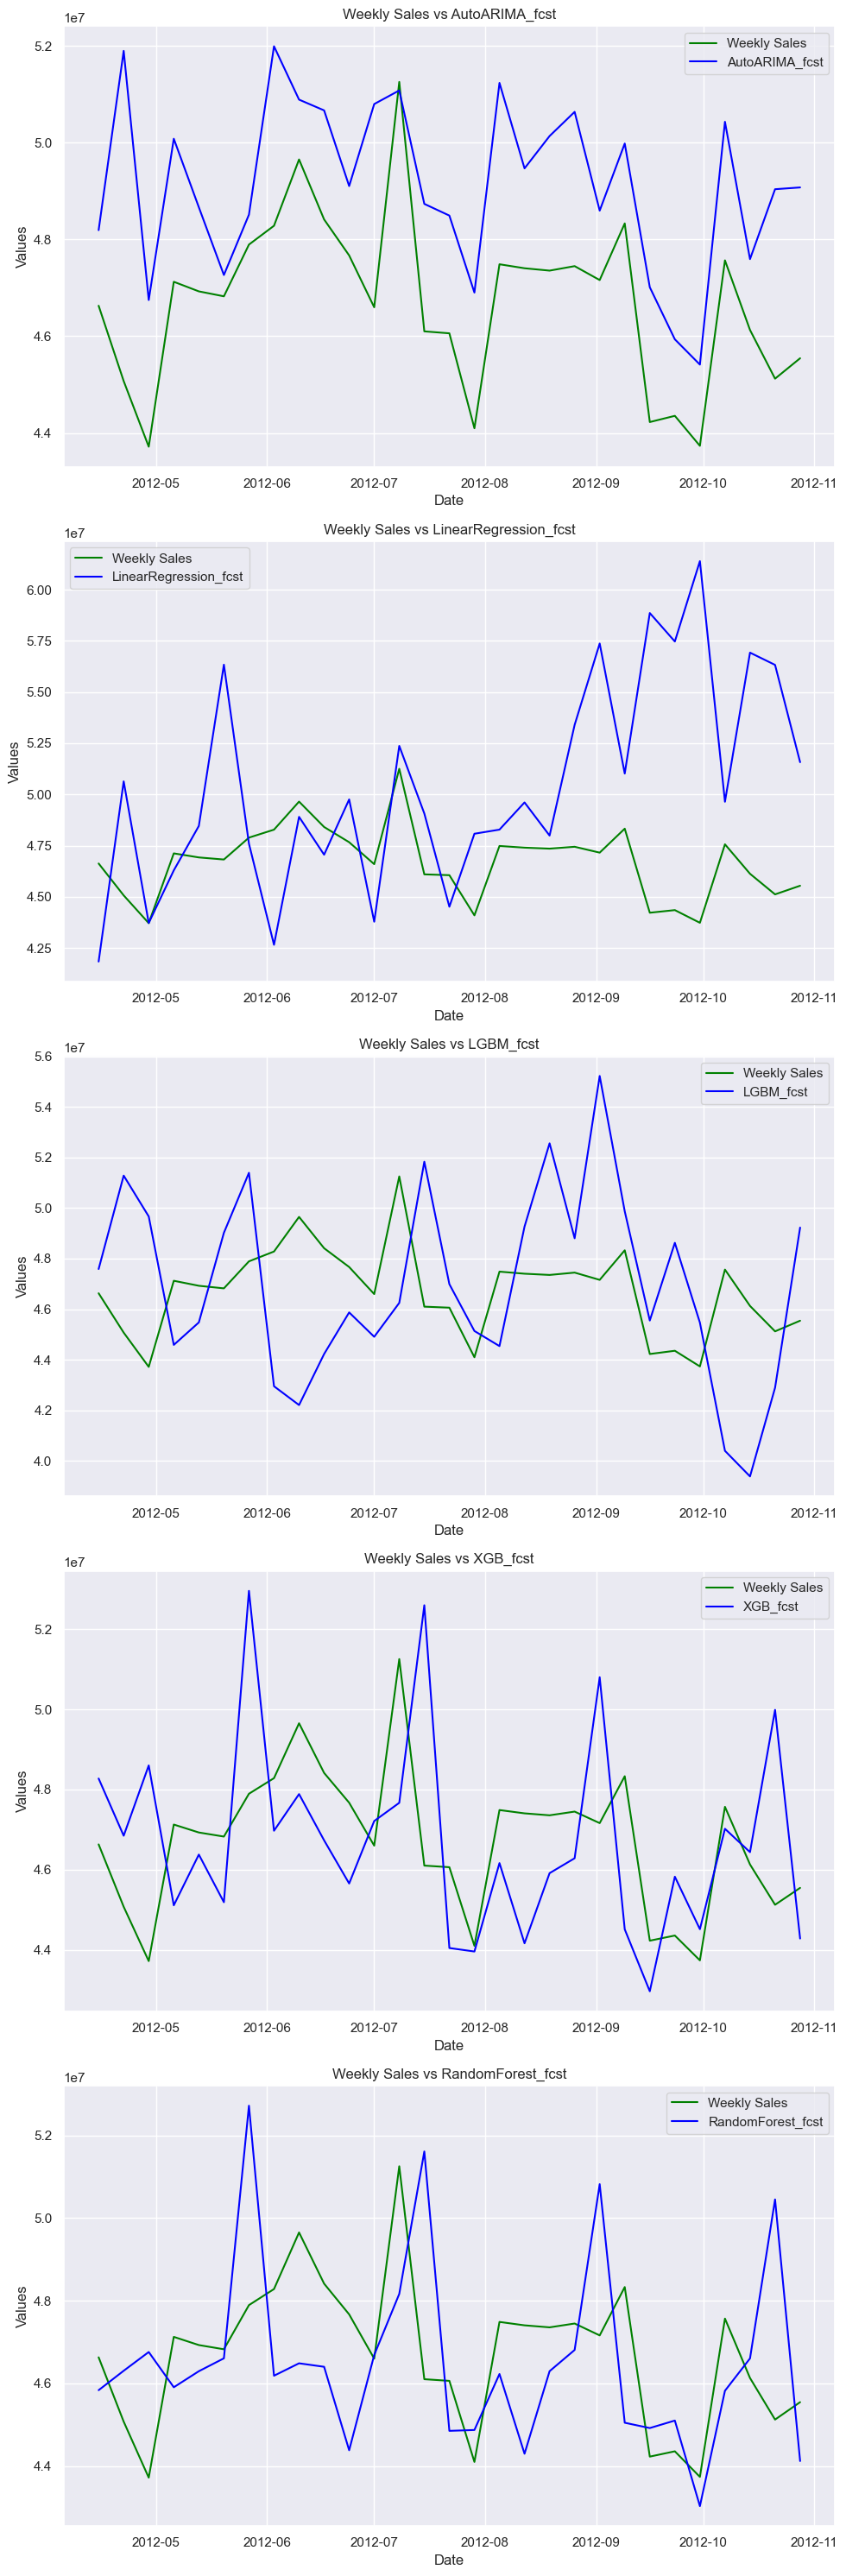

In [31]:
# Set seaborn style to darkgrid
sns.set(style="darkgrid")

# Create subplots for each prediction column
num_cols = len(result.columns[1:])
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, 6 * num_cols))

# Loop through each prediction column and plot on separate subplot
for i, col in enumerate(result.columns[1:]):  # Exclude 'Weekly_Sales'
    axes[i].plot(result.index, result['Weekly_Sales'], label='Weekly Sales', color='green')
    axes[i].plot(result.index, result[col], label=col, color='blue')
    axes[i].set_title(f'Weekly Sales vs {col}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Values')
    axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [32]:
#Links
#https://www.analyticsvidhya.com/blog/2024/02/timegpt-revolutionizing-time-series-forecasting/
#https://medium.com/analytics-vidhya/assessment-of-accuracy-metrics-for-time-series-forecasting-bc115b655705

In [33]:
import re

original_string = 'abc/{xx}/sam.com'
replacement_value = '1'

# Use regular expression to replace {xx} with the replacement value
new_string = re.sub(r'\{xx\}', replacement_value, original_string)
print(new_string)  # Output: 'abc/1/sam.com'


abc/1/sam.com
